In [1]:
import os

import numpy as np
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt


import cv2
from sklearn.utils import shuffle

from config import Config
from keras.utils import np_utils

Using TensorFlow backend.


In [2]:

def load_samples(csv_file):
    data = pd.read_csv(os.path.join('data_files',csv_file))
    data = data[['FileName', 'Label', 'ClassName']]
    file_names = list(data.iloc[:,0])
    # Get the labels present in the second column
    labels = list(data.iloc[:,1])
    samples=[]
    for samp,lab in zip(file_names,labels):
        samples.append([samp,lab])
    return samples


In [3]:
data_path = 'flowers_recognition_train.csv'
samples = load_samples(data_path)

In [4]:
print (samples[0:5])

[['flowers_renamed\\daisy\\daisy_000001.png', 0], ['flowers_renamed\\daisy\\daisy_000002.png', 0], ['flowers_renamed\\daisy\\daisy_000003.png', 0], ['flowers_renamed\\daisy\\daisy_000004.png', 0], ['flowers_renamed\\daisy\\daisy_000005.png', 0]]


In [5]:
print (samples[-15:-10])

[['flowers_renamed\\tulip\\tulip_000969.png', 4], ['flowers_renamed\\tulip\\tulip_000970.png', 4], ['flowers_renamed\\tulip\\tulip_000971.png', 4], ['flowers_renamed\\tulip\\tulip_000972.png', 4], ['flowers_renamed\\tulip\\tulip_000973.png', 4]]


In [6]:
def shuffle_data(data):
    data = shuffle(data)#,random_state=2)
    return data

In [7]:
root_dir = r'D:\Trainings-2019\custom_data_generator\flowers_recognition'

In [8]:
def generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join(root_dir,img_name))
                
                # apply any kind of preprocessing
                img = cv2.resize(img,(resize,resize))
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [9]:
# this will create a generator object
train_datagen = generator(samples,batch_size=8)

x,y = next(train_datagen)


In [10]:
print ('x_shape: ', x.shape)
print ('labels: ', y)


x_shape:  (8, 224, 224, 3)
labels:  [0 1 1 2 3 4 4 4]


<module 'matplotlib.pyplot' from 'C:\\Users\\uid38717\\AppData\\Local\\Continuum\\Anaconda3\\envs\\keras_env\\lib\\site-packages\\matplotlib\\pyplot.py'>

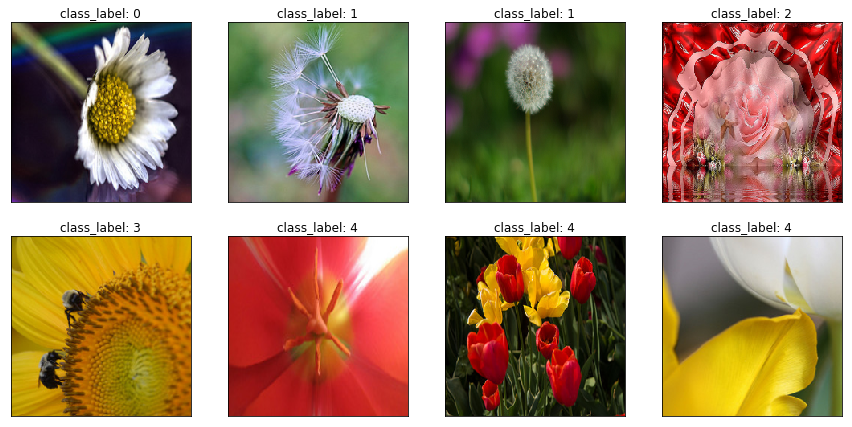

In [11]:
#### we can plot the data and see by ourselves
fig = plt.figure(1,figsize=(12,12))
for i in range(8):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  #x[i] = x[i][:,:,::-1] # converting BGR to RGB
  plt.imshow(x[i][:,:,::-1], interpolation='none')
  plt.title("class_label: {}".format(y[i]))
  plt.xticks([])
  plt.yticks([])
plt

#### we need a bit of more preparation like normalizing the data and converting the labels to one hot encoding

In [12]:
def preprocessing(img,label):
    img = cv2.resize(img,(Config.resize,Config.resize))
    img = img/255
    label = np_utils.to_categorical(label, Config.num_classes)
    return img,label

In [13]:
def data_generator(samples, batch_size=32,shuffle_data=True,resize=224):
    """
    Yields the next training batch.
    Suppose `samples` is an array [[image1_filename,label1], [image2_filename,label2],...].
    """
    num_samples = len(samples)
    while True: # Loop forever so the generator never terminates
        samples = shuffle(samples)

        # Get index to start each batch: [0, batch_size, 2*batch_size, ..., max multiple of batch_size <= num_samples]
        for offset in range(0, num_samples, batch_size):
            # Get the samples you'll use in this batch
            batch_samples = samples[offset:offset+batch_size]

            # Initialise X_train and y_train arrays for this batch
            X_train = []
            y_train = []

            # For each example
            for batch_sample in batch_samples:
                # Load image (X) and label (y)
                img_name = batch_sample[0]
                label = batch_sample[1]
                img =  cv2.imread(os.path.join(root_dir,img_name))
                
                # apply any kind of preprocessing
                img,label = preprocessing(img,label)
                # Add example to arrays
                X_train.append(img)
                y_train.append(label)

            # Make sure they're numpy arrays (as opposed to lists)
            X_train = np.array(X_train)
            y_train = np.array(y_train)

            # The generator-y part: yield the next training batch            
            yield X_train, y_train

In [14]:
# this will create a generator object
train_datagen = data_generator(samples,batch_size=8)

x,y = next(train_datagen)
print ('x_shape: ', x.shape)
print ('labels shape: ', y.shape)
print ('labels: ', y)

x_shape:  (8, 224, 224, 3)
labels shape:  (8, 5)
labels:  [[1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


#### Now we have a data loader ready to serve us the data. Let's define a CNN model in Keras and train it

In [15]:
train_data_path = 'flowers_recognition_train.csv'
test_data_path = 'flowers_recognition_test.csv'

train_samples = load_samples(train_data_path)
test_samples = load_samples(test_data_path)

num_train_samples = len(train_samples)
num_test_samples = len(test_samples)

print ('number of train samples: ', num_train_samples)
print ('number of test samples: ', num_test_samples)

number of train samples:  4023
number of test samples:  300


In [16]:
# Create generator
batch_size = Config.batch_size
train_generator = data_generator(train_samples, batch_size=32)
validation_generator = data_generator(test_samples, batch_size=32)


In [17]:
# import the necessary modules from the library
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation, MaxPooling2D, Dropout

input_shape = (Config.resize,Config.resize,3)
print (input_shape)

model = Sequential()

#filters,kernel_size,strides=(1, 1),padding='valid',data_format=None,dilation_rate=(1, 1),activation=None,use_bias=True,
#kernel_initializer='glorot_uniform',bias_initializer='zeros',kernel_regularizer=None,bias_regularizer=None,
#activity_regularizer=None,kernel_constraint=None,bias_constraint=None,

#pool_size=(2, 2), strides=None, padding='valid',data_format=None

model.add(Conv2D(32, (3,3),padding='same',input_shape=input_shape,name='conv2d_1'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_1'))

model.add(Conv2D(32, (3, 3),name='conv2d_2'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2),name='maxpool2d_2'))

model.add(Dropout(0.5))

#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(Convolution2D(64, 3, 3))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(Config.num_classes))
model.add(Activation('softmax'))

(224, 224, 3)


In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 224, 224, 32)      0         
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
activation_2 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
maxpool2d_2 (MaxPooling2D)   (None, 55, 55, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 55, 55, 32)        0         
__________

In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [20]:
model.fit_generator(
        train_generator,
        steps_per_epoch=num_train_samples // batch_size,
        epochs=Config.num_epochs,
        validation_data=validation_generator,
        validation_steps=num_test_samples // batch_size)
model.save_weights('first_try.h5') 

Epoch 1/10
402/402 [==============================] - 1249s 3s/step - loss: 1.1912 - acc: 0.5431 - val_loss: 1.1057 - val_acc: 0.6333
Epoch 2/10
402/402 [==============================] - 1245s 3s/step - loss: 0.7368 - acc: 0.7438 - val_loss: 1.0109 - val_acc: 0.6667
Epoch 3/10
402/402 [==============================] - 10348s 26s/step - loss: 0.4385 - acc: 0.8529 - val_loss: 1.0953 - val_acc: 0.6467
Epoch 4/10
  5/402 [..............................] - ETA: 21:18 - loss: 0.2822 - acc: 0.8750

KeyboardInterrupt: 